# DCGAN

[Pytorch Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [ ]:
#%matplotlib inline
from tqdm.auto import tqdm
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results


Random Seed:  999


In [ ]:
batch_size = 128

latent_dim_size = 100

generator_num_features = 64
discriminator_num_features = 64

num_epochs = 5

lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_transform = transforms.Compose([
    transforms.ToTensor(),
])

fm_dataset = FashionMNIST('./FashionMNIST', download=True, transform=image_transform)

dataloader = torch.utils.data.DataLoader(fm_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 9254367.04it/s] 


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 157709.93it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2939560.67it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21252241.13it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



In [ ]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and hasattr(m, 'weight'):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Dbg(nn.Module):
    def forward(self, tensor):
        print("tensor", tensor.shape)
        return tensor

### Generator

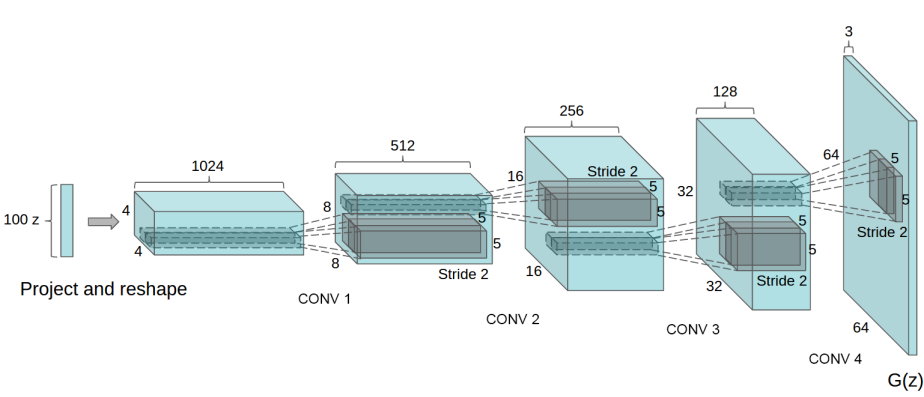

In [ ]:
# Generator Code
# TODO взять датасет с 64 64

class GeneratorUpsampleConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input ~ [ bs, latent_dim_size, 1, 1 ]
            nn.Upsample( [ 7, 7 ] ), # [ bs, generator_num_features*8, 7, 7 ]
            nn.Conv2d(latent_dim_size, generator_num_features * 8, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample( [ 14, 14 ] ), # [ bs, generator_num_features, 14, 14 ]
            nn.BatchNorm2d(generator_num_features * 8),
            nn.Conv2d(generator_num_features * 8, generator_num_features, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample( [ 28, 28 ] ), # [ bs, generator_num_features, 28, 28 ]
            nn.BatchNorm2d(generator_num_features),
            nn.Conv2d(generator_num_features, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class GeneratorConvTranspose2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input ~ [ bs, latent_dim_size, 1, 1 ]
            nn.ConvTranspose2d( latent_dim_size, generator_num_features * 8, kernel_size=7, bias=False), # [ bs, generator_num_features*8, 7, 7 ]
            nn.ReLU(True),
            nn.BatchNorm2d(generator_num_features * 8),
            nn.ConvTranspose2d(generator_num_features * 8, generator_num_features, kernel_size=4, stride=2, padding=1, bias=False), # ~ [ bs, generator_num_features, 14, 14 ]
            nn.ReLU(True),
            nn.BatchNorm2d(generator_num_features),
            nn.ConvTranspose2d( generator_num_features, 1, kernel_size=4, stride=2, padding=1, bias=False), # ~ [ bs, generator_num_features, 28, 28 ]
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
fm_dataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
netG = GeneratorUpsampleConv().to(device)
generated = netG( torch.rand([ 3, latent_dim_size, 1, 1 ]).to(device) )
assert generated.shape == torch.Size([3, 1, 28, 28])

In [ ]:
netG = GeneratorConvTranspose2d().to(device)
generated = netG( torch.rand([ 3, latent_dim_size, 1, 1 ]).to(device) )
assert generated.shape == torch.Size([3, 1, 28, 28])

In [ ]:
# Create the generator
# netG = GeneratorConvTranspose2d().to(device)
netG = GeneratorUpsampleConv().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

netG( torch.rand([ 3, latent_dim_size, 1, 1 ]).to(device) ).shape

GeneratorUpsampleConv(
  (main): Sequential(
    (0): Upsample(size=[7, 7], mode='nearest')
    (1): Conv2d(100, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Upsample(size=[14, 14], mode='nearest')
    (5): Conv2d(512, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Upsample(size=[28, 28], mode='nearest')
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)


torch.Size([3, 1, 28, 28])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input ~ [ bs, 1, 28, 28 ]
            # Dbg(),
            nn.Conv2d(1, discriminator_num_features, kernel_size=4, stride=2, padding=1, bias=False), # ~ [ bs, discriminator_num_features, 14, 14 ]
            nn.LeakyReLU(0.2, inplace=True),
            # Dbg(),
            nn.Conv2d(discriminator_num_features, discriminator_num_features * 8, kernel_size=4, stride=2, padding=1, bias=False), # ~ [ bs, discriminator_num_features * 8, 7, 7 ]
            nn.BatchNorm2d(discriminator_num_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Dbg(),
            nn.Conv2d(discriminator_num_features * 8, 1, kernel_size=7, bias=False), # ~ [ bs, 1, 1, 1 ]
            nn.Flatten(1), # [ bs, 1 ]
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

netD.forward(next(iter(dataloader))[0].to(device)).shape

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Sigmoid()
  )
)


torch.Size([128, 1])

In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, latent_dim_size, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

netG = GeneratorConvTranspose2d().to(device)
# netG = GeneratorUpsampleConv().to(device) ## uncomment to test upsample + conv variant
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(tqdm(dataloader), 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real batch
        netD.zero_grad()

        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_images).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        D_x = output.mean().item()

        ## Train with all-fake batch

        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim_size, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        D_total_loss = (errD_real + errD_fake)
        D_total_loss.backward()

        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # fake = netG(noise)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


  0%|          | 0/469 [00:00<?, ?it/s]

[0/5][0/469]	Loss_D: 2.1661	Loss_G: 2.0651	D(x): 0.7541	D(G(z)): 0.7017 / 0.2324
[0/5][50/469]	Loss_D: 0.0148	Loss_G: 5.9046	D(x): 0.9931	D(G(z)): 0.0067 / 0.0049
[0/5][100/469]	Loss_D: 0.0053	Loss_G: 6.7861	D(x): 0.9981	D(G(z)): 0.0033 / 0.0020
[0/5][150/469]	Loss_D: 0.1143	Loss_G: 5.8275	D(x): 0.9586	D(G(z)): 0.0539 / 0.0133
[0/5][200/469]	Loss_D: 0.0796	Loss_G: 4.4528	D(x): 0.9613	D(G(z)): 0.0231 / 0.0253
[0/5][250/469]	Loss_D: 0.1061	Loss_G: 4.3305	D(x): 0.9491	D(G(z)): 0.0256 / 0.0303
[0/5][300/469]	Loss_D: 0.0526	Loss_G: 4.0196	D(x): 0.9814	D(G(z)): 0.0303 / 0.0290
[0/5][350/469]	Loss_D: 0.1376	Loss_G: 4.5200	D(x): 0.9690	D(G(z)): 0.0903 / 0.0237
[0/5][400/469]	Loss_D: 0.0705	Loss_G: 4.3730	D(x): 0.9861	D(G(z)): 0.0507 / 0.0275
[0/5][450/469]	Loss_D: 0.0780	Loss_G: 3.8039	D(x): 0.9686	D(G(z)): 0.0403 / 0.0377


  0%|          | 0/469 [00:00<?, ?it/s]

[1/5][0/469]	Loss_D: 0.0644	Loss_G: 4.2020	D(x): 0.9724	D(G(z)): 0.0318 / 0.0253
[1/5][50/469]	Loss_D: 0.0800	Loss_G: 4.1800	D(x): 0.9653	D(G(z)): 0.0370 / 0.0277
[1/5][100/469]	Loss_D: 0.0890	Loss_G: 4.0897	D(x): 0.9508	D(G(z)): 0.0308 / 0.0302
[1/5][150/469]	Loss_D: 0.0551	Loss_G: 4.2277	D(x): 0.9808	D(G(z)): 0.0339 / 0.0237
[1/5][200/469]	Loss_D: 0.0525	Loss_G: 3.9968	D(x): 0.9802	D(G(z)): 0.0304 / 0.0268
[1/5][250/469]	Loss_D: 0.0550	Loss_G: 4.7547	D(x): 0.9726	D(G(z)): 0.0252 / 0.0160
[1/5][300/469]	Loss_D: 0.0810	Loss_G: 4.3843	D(x): 0.9426	D(G(z)): 0.0104 / 0.0241
[1/5][350/469]	Loss_D: 0.0513	Loss_G: 4.5652	D(x): 0.9837	D(G(z)): 0.0327 / 0.0175
[1/5][400/469]	Loss_D: 0.0571	Loss_G: 4.8107	D(x): 0.9784	D(G(z)): 0.0332 / 0.0136
[1/5][450/469]	Loss_D: 0.0761	Loss_G: 4.6046	D(x): 0.9830	D(G(z)): 0.0492 / 0.0160


  0%|          | 0/469 [00:00<?, ?it/s]

[2/5][0/469]	Loss_D: 0.0568	Loss_G: 4.6076	D(x): 0.9769	D(G(z)): 0.0312 / 0.0166
[2/5][50/469]	Loss_D: 0.0790	Loss_G: 4.7076	D(x): 0.9779	D(G(z)): 0.0472 / 0.0164
[2/5][100/469]	Loss_D: 0.0633	Loss_G: 4.5980	D(x): 0.9690	D(G(z)): 0.0292 / 0.0185
[2/5][150/469]	Loss_D: 0.0848	Loss_G: 3.6252	D(x): 0.9733	D(G(z)): 0.0509 / 0.0464
[2/5][200/469]	Loss_D: 0.0549	Loss_G: 4.5685	D(x): 0.9882	D(G(z)): 0.0401 / 0.0179
[2/5][250/469]	Loss_D: 0.0982	Loss_G: 3.8719	D(x): 0.9245	D(G(z)): 0.0124 / 0.0348
[2/5][300/469]	Loss_D: 0.3431	Loss_G: 4.5515	D(x): 0.9665	D(G(z)): 0.2219 / 0.0257
[2/5][350/469]	Loss_D: 0.0443	Loss_G: 4.3692	D(x): 0.9739	D(G(z)): 0.0163 / 0.0234
[2/5][400/469]	Loss_D: 0.2727	Loss_G: 1.6239	D(x): 0.8274	D(G(z)): 0.0218 / 0.3395
[2/5][450/469]	Loss_D: 0.0810	Loss_G: 3.9531	D(x): 0.9637	D(G(z)): 0.0386 / 0.0339


  0%|          | 0/469 [00:00<?, ?it/s]

[3/5][0/469]	Loss_D: 0.0651	Loss_G: 4.5713	D(x): 0.9739	D(G(z)): 0.0354 / 0.0173
[3/5][50/469]	Loss_D: 0.1501	Loss_G: 3.3804	D(x): 0.8927	D(G(z)): 0.0136 / 0.0586
[3/5][100/469]	Loss_D: 0.0677	Loss_G: 4.2428	D(x): 0.9697	D(G(z)): 0.0342 / 0.0224
[3/5][150/469]	Loss_D: 0.1616	Loss_G: 4.6329	D(x): 0.8957	D(G(z)): 0.0249 / 0.0396
[3/5][200/469]	Loss_D: 0.1117	Loss_G: 3.9483	D(x): 0.9617	D(G(z)): 0.0615 / 0.0324
[3/5][250/469]	Loss_D: 0.1357	Loss_G: 4.6903	D(x): 0.9693	D(G(z)): 0.0882 / 0.0147
[3/5][300/469]	Loss_D: 0.1439	Loss_G: 2.9908	D(x): 0.9107	D(G(z)): 0.0207 / 0.0788
[3/5][350/469]	Loss_D: 0.1898	Loss_G: 4.0117	D(x): 0.9584	D(G(z)): 0.1194 / 0.0315
[3/5][400/469]	Loss_D: 0.0772	Loss_G: 3.7441	D(x): 0.9627	D(G(z)): 0.0357 / 0.0400
[3/5][450/469]	Loss_D: 0.0821	Loss_G: 3.8781	D(x): 0.9704	D(G(z)): 0.0474 / 0.0326


  0%|          | 0/469 [00:00<?, ?it/s]

[4/5][0/469]	Loss_D: 0.1022	Loss_G: 3.9617	D(x): 0.9307	D(G(z)): 0.0222 / 0.0360
[4/5][50/469]	Loss_D: 0.3473	Loss_G: 2.2394	D(x): 0.7584	D(G(z)): 0.0015 / 0.2053
[4/5][100/469]	Loss_D: 0.1609	Loss_G: 3.9467	D(x): 0.8743	D(G(z)): 0.0051 / 0.0316
[4/5][150/469]	Loss_D: 0.1183	Loss_G: 3.9731	D(x): 0.9619	D(G(z)): 0.0682 / 0.0289
[4/5][200/469]	Loss_D: 0.1814	Loss_G: 3.1494	D(x): 0.9641	D(G(z)): 0.1149 / 0.0706
[4/5][250/469]	Loss_D: 0.1183	Loss_G: 4.1678	D(x): 0.9863	D(G(z)): 0.0929 / 0.0247
[4/5][300/469]	Loss_D: 0.1208	Loss_G: 2.9699	D(x): 0.9543	D(G(z)): 0.0629 / 0.0890
[4/5][350/469]	Loss_D: 0.2078	Loss_G: 3.5022	D(x): 0.8996	D(G(z)): 0.0663 / 0.0635
[4/5][400/469]	Loss_D: 0.2047	Loss_G: 4.0061	D(x): 0.9583	D(G(z)): 0.1273 / 0.0303
[4/5][450/469]	Loss_D: 0.1542	Loss_G: 3.3613	D(x): 0.8990	D(G(z)): 0.0185 / 0.0627


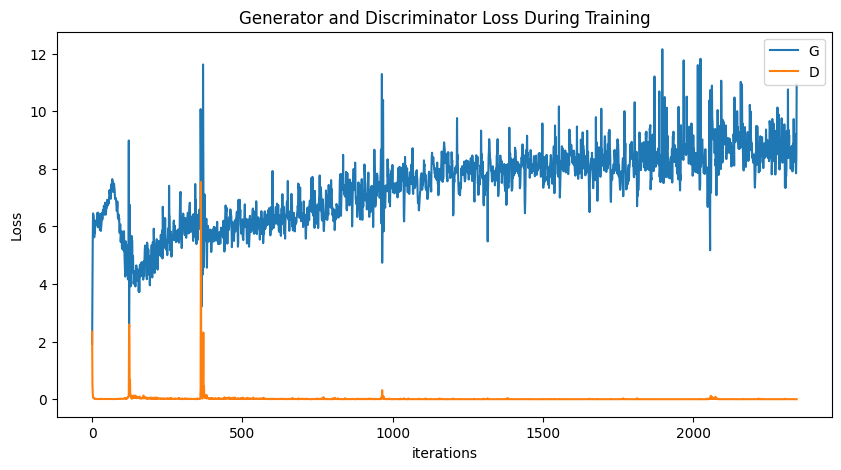

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

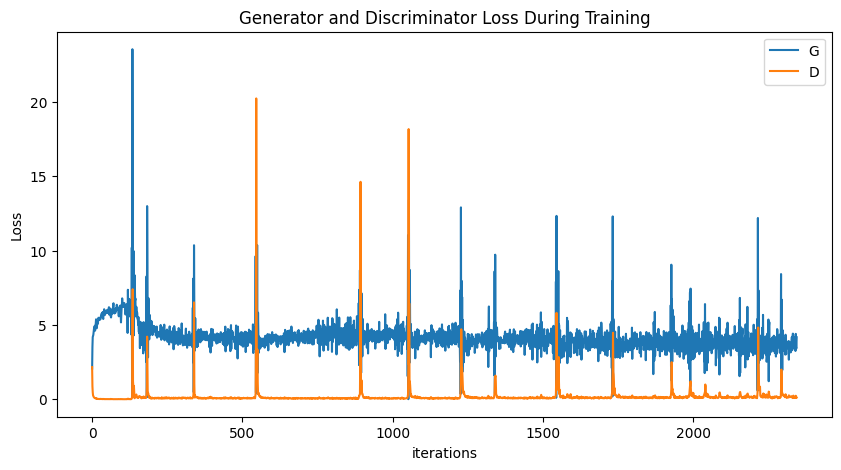

In [ ]:
# припер плохого генератора -- он не может обучиться, тк дискриминатор не ошибается

# upsample + conv generator
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

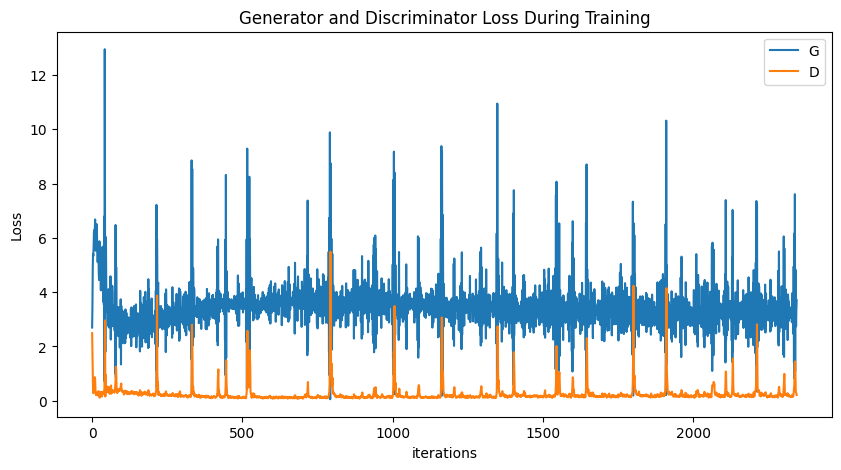

In [ ]:
# conv transpose 2d generatot
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

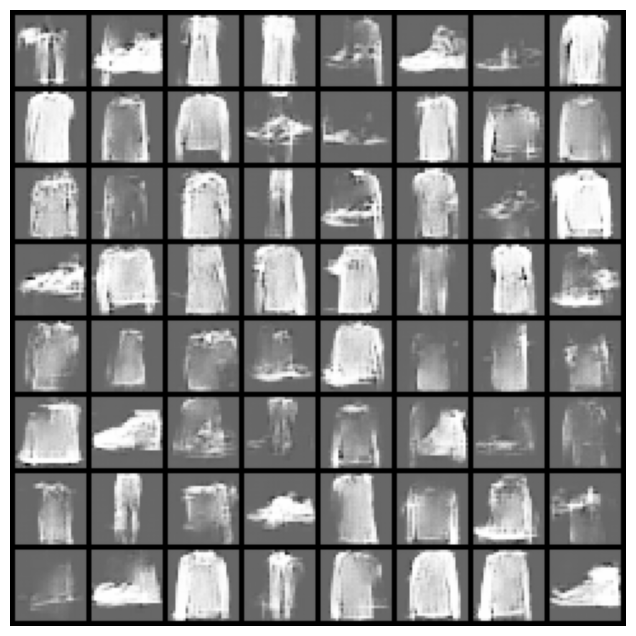

In [ ]:
# upsample + conv
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

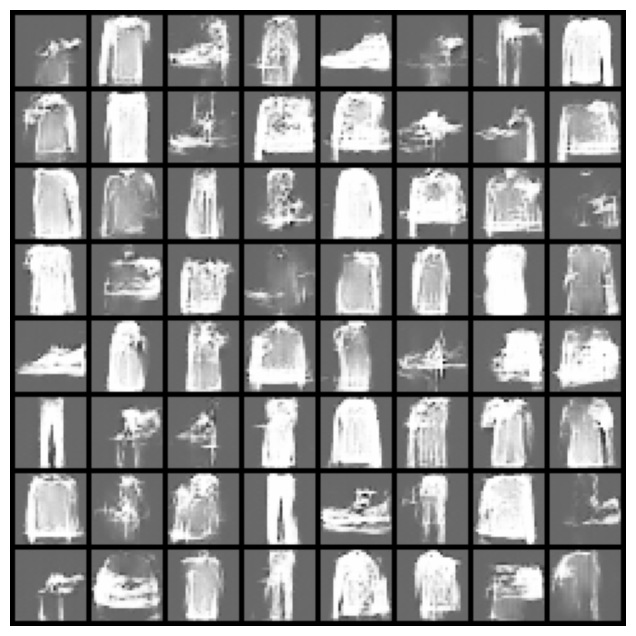

In [ ]:
# conv transpose
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Pix2Pix

[Paper](https://arxiv.org/abs/1611.07004)

[Demo](https://affinelayer.com/pixsrv/)


### Чем отличается от DCGAN?

* требует парных размеченных данных
* Архитектурно UNET, тк теперь есть кондишн (контуры)


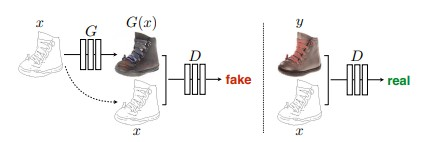

In [ ]:
# https://github.com/eriklindernoren/PyTorch-GAN/blob/36d3c77e5ff20ebe0aeefd322326a134a279b93e/implementations/pix2pix/models.py#L15

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


In [ ]:
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/pix2pix/pix2pix.py

dataloader = raise  NotImplemented()
optimizer_G = raise NotImplemented()
optimizer_D = raise NotImplemented()

lambda_pixel = 100

criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

for epoch in range(10):
    for i, batch in enumerate(dataloader):

        # Model inputs
        edges = batch["edges"]
        images = batch["image"]

        # Adversarial ground truths
        valid = torch.tensor(np.ones((edges.size(0), *patch)))
        fake =  torch.tensor(np.zeros((edges.size(0), *patch)))

        optimizer_G.zero_grad()

        # GAN loss
        fake_images = generator(edges)
        pred_fake = discriminator(fake_images, edges)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_images, images)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(images, edges)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_images.detach(), edges)
        # pred_fake = discriminator(fake_images.detach(), edges)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

# Cycle Gan

[Paper](https://arxiv.org/abs/1703.10593)

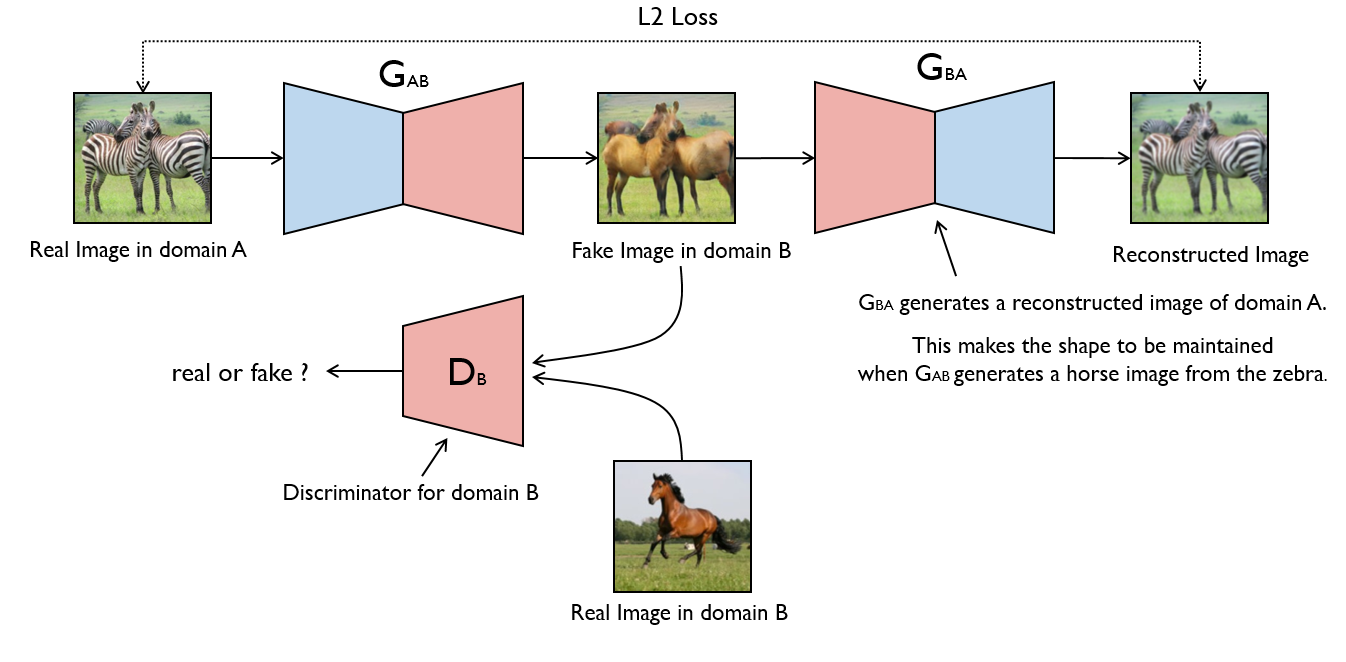

In [ ]:
# https://github.com/eriklindernoren/PyTorch-GAN/blob/36d3c77e5ff20ebe0aeefd322326a134a279b93e/implementations/cyclegan/cyclegan.py#L158

dataloader = raise  NotImplemented()
optimizer_G = raise NotImplemented()
optimizer_D = raise NotImplemented()

G_AB = raise NotImplemented()
G_BA = raise NotImplemented()

D_A = raise NotImplemented()
D_B = raise NotImplemented()

lambda_pixel = 100

criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()



for epoch in range(10):
    for i, batch in enumerate(dataloader):

        # Set model input
        real_A = batch["A"]
        real_B = batch["B"]

        # Adversarial ground truths
        valid = torch.ones((real_A.size(0), *D_A.output_shape))
        fake = torch.zeros((real_A.size(0), *D_A.output_shape))

        # ------------------
        #  Train Generators
        # ------------------

        G_AB.train() # G_AB.trainig == True
        G_BA.train()

        G_BA.zero_grad()
        G_AB.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + opt.lambda_cyc * loss_cycle + opt.lambda_id * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------

        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------

        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2


# Оценка качества сгенерированных данных

Для оценки качества моделек, отслеживания переобучения нам для всех задач и всегда хочется иметь автоматизированные метрики качества.

## Требования:

* метрика должна работать независимо от количества классов
* без дополнительной разметки человеком


## Inception Score (IS)

[Paper - Improved Techniques for Training GANs](https://arxiv.org/pdf/1606.03498) (Section 4. Assessment of image quality)

#### Интуиция и предпосылки:

1) Если на изображении есть валидный объект, классификатор должен быть достаточно уверенно определить его

> Images that contain meaningful objects should have a conditional label distribution p(y|x) with low entropy.

2) Мы хотим чтобы сеть генерировала объкты разных классов, поэтому хотим максимизировать дисперсию

> Moreover, we expect the model to generate varied images, so the marginal ∫ p(y|x = G(z))dz should have high entropy

#### Какие значения принимает?

> The inception score has a lowest value of 1.0 and a highest value of the number of classes supported by the classification model; in this case, the Inception v3 model supports the 1,000 classes -->

[Источник](https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/)


In [ ]:
# Источник https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py
# TODO это скорее псевдокод, не работает

import numpy as np
from torchvision.models.inception import inception_v3

def get_predictions(inception_model, x):
    up = nn.Upsample(size=(299, 299), mode='bilinear')
    x = up(x)
    prediction_logits = inception_model(x)
    return F.softmax(prediction_logits).cpu().numpy()

@torch.no_grad()
def inception_score(inception_model, generated_data, splits=10):
    N = len(generated_data)
    dataloader = DataLoader(generated_data, batch_size=1000)

    preds = np.zeros([ N, num_classes ])
    for i, batch in enumerate(dataloader):
        batch_size_i = batch.shape[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_predictions(inception_model, batch)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        p_y = torch.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            p_yx = part[i, :]
            # todo make calculations stable
            scores.append(np.sum(p_yx * np.log(p_yx / p_y)))

        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

inception_model = inception_v3()
is_mean, is_std = inception_score(inception_model, dataloader)

## Frechet inception distance (FID)


Paper - [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500)

### Интуиция и предпосылки:

1) IS работает на уровне распределений вероятностей классов

2) Можно спуститься на уровень ниже и использовать скрытые фича-мапы с последнего уровня Inception

3) В отличие от IS принимает на вход целевые данные для вычислениия распределения в реальных данных

### Как работает?

1) Получаем фича-мапы с последнего слоя

2) Вычисляем статистики

$$ F(N_b, N_e) = ‖ \mu_b - \mu_e ‖^2 + tr(\Sigma_b + \Sigma_e - 2\sqrt{\Sigma_b\Sigma_e}) $$

3) Авторы утверждают, что FID лучше улавливает похожесть сгенерированных изображений с реальными данными

--

PS кстати, для оценки генерации аудио есть аналоичная метика - `FAD` ([Frechet audio distance](https://arxiv.org/pdf/1812.08466))


### Какие значения может принимать?


$$
[ 0, \inf )
$$

In [ ]:
# Pseudocode
# https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py#L281

def calculate_fid_given_paths(paths, batch_size):

    model = InceptionV3().to(device)

    m1, s1 = compute_statistics_of_path(
        paths[0], model, batch_size, dims, device, num_workers
    )
    m2, s2 = compute_statistics_of_path(
        paths[1], model, batch_size, dims, device, num_workers
    )
    fid_value = (mu1 - mu2).pow(2) + np.trace( s1 + s2 - 2 * np.sqrt( s1 @ s2 ) )

    return fid_value


# Блиц

### Чем по сути является Дискриминатор в процессе обучения ганов?

<!-- Дискриминатор можно интерпретировать как обучаемый лосс -->


### Зачем нам нужно 2 оптимизатора во время обучения ганов?

<!-- Потому что у нас 2 модели -- дискриминатор и генератор -->

### В чем недостатки Pix2Pix моделей?

<!-- Они требуют размеченных парных данных -- их не всегда легко найти и разметить -->

### Что будет если мы уберем `optimizer_D.zero_grad()` после оптимизации генератора перед оптимизацией дискриминатора?

<!-- В дискриминатре сохранятся градиенты, которые мы получили во время оптимизации генератора. После суммы с новыми градиентами на шаге оптимизации дискриминатора в хорошем случае дискриминатор просто не обучится. В плохомм случае дискриминатор будет "глупеть" -- учиться не находить различий между фейковыми и сгенеренными данными -->

### Что будет если мы уберем `.detach()` в месте вычисления фейковой составляющей для дискриминатора?

```
        # Optimize gegrator
        fake_images = generator(edges)
        # ...

        # Optimize discriminator

        # Fake loss
        pred_fake = discriminator(fake_images.detach(), edges)
        ...
```



<!-- На самом деле, кажется, что ничего не сломается. Просто градиенты потекут на генератор. Но тк перед оптимизацией генератора мы зануляем градиенты -- это не сломает обучение. Но процесс тренировки будет требовать больше памяти -->

### Какие проблемы есть в обучении ганов?

<!--
* Нестабильное обучение
* mode collapse - генератор обучается обманывать дискриминатор, а не воспроизводить исходное распределение
-->


### В чем переимущества `CycleGAN`'ов по сравнению `Pix2Pix`?

<!-- Cycle GAN не требует размеченных пар картинок -->

### Чем DCGan отличается от GAN?

<!--
Архитектурой -- DCGan использует сверточные сети и для дискриминатроа,
и для генератора.

| Особенность                 | GAN (базовый)            | DCGAN                                              |
| --------------------------- | ------------------------ | -------------------------------------------------- |
| Тип слоев                   | Полносвязные (dense)     | Сверточные (Conv/ConvTranspose)                    |
| Генератор использует        | Dense → reshape (обычно) | ConvTranspose (деконволюции)                       |
| Дискриминатор использует    | Dense-слои               | Convolutional-слои                                 |
| BatchNorm                   | Не обязателен            | Активно используется в генераторе и дискриминаторе |
| Активации                   | Разные                   | ReLU (генератор), LeakyReLU (дискриминатор)        |
| Подходит для изображений?   | Ограниченно              | Да, хорошо подходит                                |
| Устойчивость и стабильность | Ниже                     | Лучше (благодаря нормализации и сверткам)          |


 -->

### Как измерить качество сгенерированных картинок?

<!-- FID / IS -- метрики построенные на оценке распределений в пространстве фича-мап  -->


### Как вычисляется IS?

<!-- На основе распределения вероятносетей предсказанных классов. Пример реальных данных для вычисления не нужен. -->

### На основе чего вычисляется FID?

<!-- На основе активаций промежуточных слоев IS. Сравниваются распределения гауссиан распределний реальный данных и сгенерированных -->

### Что лучше использовать `IS` или `FID`?

<!-- На практике обычно смотрят сразу обе метрики -->


### Верно ли что если сделать `model.eval()` градиенты для такой модели не вычисляются? Чтобы градиенты вычислялись надо вызвать `.train()`.

<!-- Обе части вопроса это неверно. `train()/eval()` влияют на работу Dropout/BatchNorm слоев. На вычисление градиентов эти методы не влияют

Чтобы отключить вычисление градиентов, можно использовать контекстный менеждер
* `with torch.no_grad()`
* декоратор `@torch.no_grad()`
* пройтись по параметрам модели и выключить флаг `.requires_grad`:

```
p.requires_grad = False for p in model.parameters()
```
 -->